# Finding the Perfect Match
Project Brief: Despite the fact that it is easier to communicate with each other now than it has been in the past, establishing meaningful, personal connections with persons of similar interests is becoming increasingly difficult. We want to change that by providing a service where users are matched according to their interests, values and preferences.

## Import Libraries

In [1]:
# Standard ML Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Natural Language Processing
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
import nltk
nltk.download('wordnet')

# Data Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Model Training
from sklearn.cluster import KMeans, AgglomerativeClustering

# Model Evaluation
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import confusion_matrix, classification_report

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Misc Libraries
from sklearn.pipeline import Pipeline
from tqdm import tqdm_notebook as tqdm
import random


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jasjones82/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load and Check Data

In [2]:
df = pd.read_csv('DATA/okcupid_profiles.csv')

In [3]:
df.head()

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,...,i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN
2,38,available,m,straight,thin,anything,socially,NaN,graduated from masters program,NaN,...,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ..."
3,23,single,m,straight,thin,vegetarian,socially,NaN,working on college/university,white,...,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",...,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at: http://bagsbrown....,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians at the moment...",NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 31 columns):
age            59946 non-null int64
status         59946 non-null object
sex            59946 non-null object
orientation    59946 non-null object
body_type      54650 non-null object
diet           35551 non-null object
drinks         56961 non-null object
drugs          45866 non-null object
education      53318 non-null object
ethnicity      54266 non-null object
height         59943 non-null float64
income         59946 non-null int64
job            51748 non-null object
last_online    59946 non-null object
location       59946 non-null object
offspring      24385 non-null object
pets           40025 non-null object
religion       39720 non-null object
sign           48890 non-null object
smokes         54434 non-null object
speaks         59896 non-null object
essay0         54458 non-null object
essay1         52374 non-null object
essay2         50308 non-null object
essa

In [5]:
# Missing Values
df.isnull().sum().sort_values(ascending=False)

offspring      35561
diet           24395
religion       20226
pets           19921
essay8         19225
drugs          14080
essay6         13771
essay9         12603
essay7         12451
essay3         11476
sign           11056
essay5         10850
essay4         10537
essay2          9638
job             8198
essay1          7572
education       6628
ethnicity       5680
smokes          5512
essay0          5488
body_type       5296
drinks          2985
speaks            50
height             3
orientation        0
status             0
sex                0
income             0
last_online        0
location           0
age                0
dtype: int64

## EDA

In [6]:
df.describe().round(1) # Summary statistics for numerical variables

,age,height,income
count,59946.0,59943.0,59946.0
mean,32.3,68.3,20033.2
std,9.5,4.0,97346.2
min,18.0,1.0,-1.0
25%,26.0,66.0,-1.0
50%,30.0,68.0,-1.0
75%,37.0,71.0,-1.0
max,110.0,95.0,1000000.0


## Feature Engineering
Perform data transformation to address the following:
1. Missing Values
2. Natural Language Processing
3. Categorical Variables
4. Scaling, Normalization

### Missing Values

In [7]:
df[['essay0', 'essay1', 'essay2', 'essay3', 'essay4','essay5', 'essay6', 'essay7', 'essay8', 'essay9']].isnull().sum()/len(df)*100

essay0     9.154906
essay1    12.631368
essay2    16.077803
essay3    19.143896
essay4    17.577486
essay5    18.099623
essay6    22.972342
essay7    20.770360
essay8    32.070530
essay9    21.023922
dtype: float64

In [8]:
df = df.dropna()

In [9]:
df.isnull().sum()

age            0
status         0
sex            0
orientation    0
body_type      0
diet           0
drinks         0
drugs          0
education      0
ethnicity      0
height         0
income         0
job            0
last_online    0
location       0
offspring      0
pets           0
religion       0
sign           0
smokes         0
speaks         0
essay0         0
essay1         0
essay2         0
essay3         0
essay4         0
essay5         0
essay6         0
essay7         0
essay8         0
essay9         0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4407 entries, 0 to 59944
Data columns (total 31 columns):
age            4407 non-null int64
status         4407 non-null object
sex            4407 non-null object
orientation    4407 non-null object
body_type      4407 non-null object
diet           4407 non-null object
drinks         4407 non-null object
drugs          4407 non-null object
education      4407 non-null object
ethnicity      4407 non-null object
height         4407 non-null float64
income         4407 non-null int64
job            4407 non-null object
last_online    4407 non-null object
location       4407 non-null object
offspring      4407 non-null object
pets           4407 non-null object
religion       4407 non-null object
sign           4407 non-null object
smokes         4407 non-null object
speaks         4407 non-null object
essay0         4407 non-null object
essay1         4407 non-null object
essay2         4407 non-null object
essay3         4407 non-null 

### Natural Language Processing
Creating the tokenizer (Credit: Marco Santos, https://medium.com/swlh/using-nlp-machine-learning-on-dating-profiles-1d9328484e85)

In [11]:
# Instantiating the lemmatizer

lemmatizer = WordNetLemmatizer()

In [12]:
# Tokenizing Function

def tokenize(text):
    """
    Tokenizing the bios, then lemmatizing them
    
    """
    # Create a library of stopwords
    stops = stopwords.words('english')
    
    # Convert words to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.replace('.', ' ')
    
    # Split on spaces between words
    text = text.split(' ')
    
    # Lemmatize the words and remove stop words
    text = [lemmatizer.lemmatize(i) for i in text if i not in stops]
    
    return text

Apply 'tokenize' function to each essay column

In [13]:
df['essay0'] = df['essay0'].apply(tokenize)
df['essay1'] = df['essay1'].apply(tokenize)
df['essay2'] = df['essay2'].apply(tokenize)
df['essay3'] = df['essay3'].apply(tokenize)
df['essay4'] = df['essay4'].apply(tokenize)
df['essay5'] = df['essay5'].apply(tokenize)
df['essay6'] = df['essay6'].apply(tokenize)
df['essay7'] = df['essay7'].apply(tokenize)
df['essay8'] = df['essay8'].apply(tokenize)
df['essay9'] = df['essay9'].apply(tokenize)

In [14]:
df['essay0'][0]

['me:',
 '',
 'would',
 'love',
 'think',
 'kind',
 'intellectual:',
 'either',
 'dumbest',
 'smart',
 'guy,',
 'smartest',
 'dumb',
 'guy',
 '',
 "can't",
 'say',
 'tell',
 'difference',
 '',
 'love',
 'talk',
 'idea',
 'concept',
 '',
 'forge',
 'odd',
 'metaphor',
 'instead',
 'reciting',
 'cliche',
 '',
 'like',
 'simularities',
 'friend',
 "mine's",
 'house',
 'underwater',
 'salt',
 'mine',
 '',
 'favorite',
 'word',
 'salt',
 'way',
 '(weird',
 'choice',
 'know)',
 '',
 'thing',
 'life',
 'better',
 'metaphor',
 '',
 'seek',
 'make',
 'little',
 'better',
 'everyday,',
 'productively',
 'lazy',
 'way',
 '',
 'got',
 'tired',
 'tying',
 'shoe',
 '',
 'considered',
 'hiring',
 'five',
 'year',
 'old,',
 'would',
 'probably',
 'tie',
 'shoe',
 '',
 '',
 '',
 'decided',
 'wear',
 'leather',
 'shoe',
 'dress',
 'shoe',
 '',
 '',
 'you:',
 '',
 'love',
 'really',
 'serious,',
 'really',
 'deep',
 'conversation',
 'really',
 'silly',
 'stuff',
 '',
 'willing',
 'snap',
 'light',
 'hear

In [15]:
df.head()

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,"[me:, , would, love, think, kind, intellectual...","[currently, working, international, agent, fre...","[making, people, laugh, , ranting, good, salti...","[way, look, , six, foot, half, asian,, half, c...","[books:, absurdistan,, republic,, mouse, men, ...","[food, , water, , cell, phone, , shelter, ]","[duality, humorous, thing]","[trying, find, someone, hang, , anything, exce...","[new, california, looking, someone, wisper, se...","[want, swept, feet!, tired, norm, , want, catc..."
19,33,single,m,straight,athletic,mostly anything,socially,never,graduated from masters program,white,...,"[relocated, san, francisco, half, year, ago, ,...","[left, comfort, zone, far, behind, europe,, en...","[listening,, connecting, emotionally,, analyzi...","[cheerful,, open,, curious,, direct,, active,,...","[art, happiness, dalai, lama,, finding, passio...","[juicy, fruit,, water,, swimming, workouts,, y...","[passion, searching, new, one, ]","[dinner, night, close, friends;, driving, town...","[i'm, pretty, direct,, ask, i'll, tell, ]","[wanna, meet, ]"
22,30,single,m,straight,fit,mostly anything,socially,never,graduated from college/university,white,...,"[tend, think, way, comedian, nearly, everythin...","[i'm, supply, demand, manager, sustainable, so...","[making, predictions,, planning, anything, (i'...","[i'm, smiling, , pretty, much, time, ]","[confederacy, dunce, infinite, jest, two, time...","[1), sf, restaurants,, could, better?, 2), fri...","[build, empire, legacy, , far, list, obtain, t...","[beer, number, friend, pretending, worked, las...","[kid, thought, steven, segal, really, cool, , ...","[positive, creative, personality, looking, new..."
94,29,single,m,straight,fit,mostly anything,socially,sometimes,graduated from college/university,white,...,"[name, josh,, create, art, living, , work, con...",[living],[everything],"[honestly, say, , , , ]","[-books:, anything, joseph, campbell, -, osho,...","[invalid, question]",[world],[],[],"[curious, ]"
98,31,single,f,straight,curvy,anything,socially,sometimes,graduated from masters program,white,...,"[one, day, mod, r/hotchickswithspreadsheets, ,...","[presently,, holyshitwhatamidoinghere, spaceti...","[algebra,, alliteration,, big, spoon, little, ...","[look, lot, like, chick, banged, freshman, yea...","[-, wikipedia, -, yes, -, yes, -, yes, -, yes]","[civility,, hope,, basic, arithmetic,, vital, ...","[macro, , also,, puppy, , worry, future,, resp...","[home,, high,, dish, ]","[i'm, terrible, small, talk, make, awkward, ev...","[find, challenge, rewarding, ]"


In [16]:
df.columns

Index(['age', 'status', 'sex', 'orientation', 'body_type', 'diet', 'drinks',
       'drugs', 'education', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'pets', 'religion', 'sign',
       'smokes', 'speaks', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4',
       'essay5', 'essay6', 'essay7', 'essay8', 'essay9'],
      dtype='object')

In [17]:
# # Create a set list that will only take in unique words

# total_vocab = set()

# # Iterate through the essays for each word
# for word in df[['essay0', 'essay1', 'essay2', 'essay3', 'essay4',
#        'essay5', 'essay6', 'essay7', 'essay8', 'essay9']]:
#     total_vocab.update(word)
    
# # Print out the number of unique words in all the essays combined
# print('Number of unique words: ', len(total_vocab))

# # Determine the most frequent words in user essays
# words = []

# # Add all the words in essays to a list
# for word in df[['essay0', 'essay1', 'essay2', 'essay3', 'essay4',
#        'essay5', 'essay6', 'essay7', 'essay8', 'essay9']]:
#     words.extend(word)
    
# # Determine the use frequency of each word in essays
# word_freq = FreqDist(words)
# word_freq.most_common()

# # Plot the most frequently used words
# plt.style.use('ggplot')
# plt.figure(figsize=(10,5))

# plt.bar(*zip(*word_freq.most_common(20)))
# plt.xticks(rotation=75)
# plt.title('Most Frequently Used Words in Essays')
# plt.show()


In [18]:
# # Instantiating the score of each bigram
# bigram_meas = BigramAssocMeasures()

# # Finding and ranking the Bigrams in each bio
# bio_finder = BigramCollocationFinder.from_words(words)

# # Finding the frequency scores of each bigram 
# bio_scored = bio_finder.score_ngrams(bigram_meas.raw_freq)

# # Top 50 most common bigrams
# bio_scored[:50]

# # Creating a list of the bigrams
# bg = list(map(lambda x: x[0][0] + ' ' + x[0][1], bio_scored[:50]))

# # Creating a list of the frequency scores
# bio_scores = list(map(lambda x: x[1], bio_scored[:50]))

# # Combining both the scores and the bigrams
# bigrams = list(zip(bg, bio_scores))

# # Plotting the bigrams and their frequency scores
# plt.style.use('bmh')
# plt.figure(figsize=(15,5))

# plt.bar(*zip(*bigrams[:25]))
# plt.xticks(rotation=80)
# plt.title('Top 25 Most Common Bigrams')
# plt.show()

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4407 entries, 0 to 59944
Data columns (total 31 columns):
age            4407 non-null int64
status         4407 non-null object
sex            4407 non-null object
orientation    4407 non-null object
body_type      4407 non-null object
diet           4407 non-null object
drinks         4407 non-null object
drugs          4407 non-null object
education      4407 non-null object
ethnicity      4407 non-null object
height         4407 non-null float64
income         4407 non-null int64
job            4407 non-null object
last_online    4407 non-null object
location       4407 non-null object
offspring      4407 non-null object
pets           4407 non-null object
religion       4407 non-null object
sign           4407 non-null object
smokes         4407 non-null object
speaks         4407 non-null object
essay0         4407 non-null object
essay1         4407 non-null object
essay2         4407 non-null object
essay3         4407 non-null 

### Categorical Variables
The following variables are objects. We will perform the following:

In [20]:
# 1st step - Separate numerical from categorical features
cat_df = df.loc[:,df.dtypes==np.object]

In [21]:
# Separating Essays from the rest of the colums
essays = cat_df.iloc[:,18:]
cat_df = cat_df.iloc[:,:18]

In [22]:
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4407 entries, 0 to 59944
Data columns (total 18 columns):
status         4407 non-null object
sex            4407 non-null object
orientation    4407 non-null object
body_type      4407 non-null object
diet           4407 non-null object
drinks         4407 non-null object
drugs          4407 non-null object
education      4407 non-null object
ethnicity      4407 non-null object
job            4407 non-null object
last_online    4407 non-null object
location       4407 non-null object
offspring      4407 non-null object
pets           4407 non-null object
religion       4407 non-null object
sign           4407 non-null object
smokes         4407 non-null object
speaks         4407 non-null object
dtypes: object(18)
memory usage: 814.2+ KB


In [23]:
# Convert lists in the df to strings

def string_convert(x):
    
    if isinstance(x, list):
        return ' '.join(x)
    else:
        return x
    
# Looping through the columns and applying the function
for col in cat_df.columns:
    cat_df[col] = cat_df[col].apply(string_convert)

In [24]:
cat_df.head()

,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,job,last_online,location,offspring,pets,religion,sign,smokes,speaks
0,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",transportation,2012-06-28-20-30,"south san francisco, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism and very serious about it,gemini,sometimes,english
19,single,m,straight,athletic,mostly anything,socially,never,graduated from masters program,white,science / tech / engineering,2012-06-27-21-41,"san francisco, california",doesn't have kids,likes dogs and likes cats,catholicism but not too serious about it,pisces and it&rsquo;s fun to think about,no,english (fluently)
22,single,m,straight,fit,mostly anything,socially,never,graduated from college/university,white,executive / management,2012-06-28-15-22,"san francisco, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism and somewhat serious about it,sagittarius but it doesn&rsquo;t matter,no,"english, spanish (poorly)"
94,single,m,straight,fit,mostly anything,socially,sometimes,graduated from college/university,white,artistic / musical / writer,2012-05-28-15-18,"san francisco, california",doesn't want kids,likes dogs and likes cats,agnosticism and very serious about it,libra,no,english (fluently)
98,single,f,straight,curvy,anything,socially,sometimes,graduated from masters program,white,executive / management,2012-06-29-06-59,"san francisco, california","doesn't have kids, but might want them",likes dogs,atheism,pisces,no,english (fluently)


In [25]:
# 2nd step - Convert all object columns to categories so that they can be encoded
cat_df = cat_df.astype('category')

In [26]:
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4407 entries, 0 to 59944
Data columns (total 18 columns):
status         4407 non-null category
sex            4407 non-null category
orientation    4407 non-null category
body_type      4407 non-null category
diet           4407 non-null category
drinks         4407 non-null category
drugs          4407 non-null category
education      4407 non-null category
ethnicity      4407 non-null category
job            4407 non-null category
last_online    4407 non-null category
location       4407 non-null category
offspring      4407 non-null category
pets           4407 non-null category
religion       4407 non-null category
sign           4407 non-null category
smokes         4407 non-null category
speaks         4407 non-null category
dtypes: category(18)
memory usage: 534.4 KB


In [27]:
# 3rd step - encode all categories
for col in cat_df:
    cat_df[col] = cat_df[col].cat.codes

In [28]:
cat_df

,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,job,last_online,location,offspring,pets,religion,sign,smokes,speaks
0,3,1,2,0,9,4,0,20,34,19,1766,73,2,14,3,16,1,0
19,3,1,2,1,2,4,0,11,103,17,1517,63,0,14,19,30,0,1
22,3,1,2,4,2,4,0,8,103,7,1683,63,2,14,2,35,0,1130
94,3,1,2,4,2,4,2,8,103,0,489,63,4,14,3,24,0,1
98,3,0,2,3,0,4,2,11,103,7,1903,63,2,11,5,28,0,1
106,3,0,2,4,2,4,0,11,0,7,1084,36,0,11,1,7,0,1
113,3,0,2,3,2,3,0,20,42,12,1736,63,5,14,40,14,3,1
121,3,1,2,4,2,4,0,15,103,20,617,77,9,3,22,19,0,828
123,3,1,2,10,9,4,1,26,58,10,2144,63,1,11,6,34,1,0
137,3,1,2,2,2,2,0,0,103,19,2316,6,4,5,40,24,0,0


In [29]:
# Drop last online column
cat_df = cat_df.drop('last_online',axis=1)

In [30]:
cat_df.head()

,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,job,location,offspring,pets,religion,sign,smokes,speaks
0,3,1,2,0,9,4,0,20,34,19,73,2,14,3,16,1,0
19,3,1,2,1,2,4,0,11,103,17,63,0,14,19,30,0,1
22,3,1,2,4,2,4,0,8,103,7,63,2,14,2,35,0,1130
94,3,1,2,4,2,4,2,8,103,0,63,4,14,3,24,0,1
98,3,0,2,3,0,4,2,11,103,7,63,2,11,5,28,0,1


#### Vectorize the Essays

In [31]:
# Converts the lists in the essay df to strings
def string_convert(x):
   
    if isinstance(x, list):
        return ' '.join(x)
    else:
        return x
    
# Looping through the columns and applying the function
for col in essays.columns:
    essays[col] = essays[col].apply(string_convert)

In [32]:
essays

,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,me: would love think kind intellectual: eithe...,currently working international agent freight ...,making people laugh ranting good salting fin...,"way look six foot half asian, half caucasian ...","books: absurdistan, republic, mouse men (only ...",food water cell phone shelter,duality humorous thing,trying find someone hang anything except club,new california looking someone wisper secret,want swept feet! tired norm want catch coffee...
19,relocated san francisco half year ago awesome...,"left comfort zone far behind europe, enjoyed m...","listening, connecting emotionally, analyzing t...","cheerful, open, curious, direct, active, sport...","art happiness dalai lama, finding passion chan...","juicy fruit, water, swimming workouts, yoga pr...",passion searching new one,dinner night close friends; driving town weekend,"i'm pretty direct, ask i'll tell",wanna meet
22,tend think way comedian nearly everything laug...,i'm supply demand manager sustainable soap man...,"making predictions, planning anything (i'm pre...",i'm smiling pretty much time,confederacy dunce infinite jest two time favor...,"1) sf restaurants, could better? 2) friend bee...",build empire legacy far list obtain two atv's...,beer number friend pretending worked last day ...,kid thought steven segal really cool please j...,positive creative personality looking new adve...
94,"name josh, create art living work conceptual ...",living,everything,honestly say,-books: anything joseph campbell - osho - terr...,invalid question,world,,,curious
98,one day mod r/hotchickswithspreadsheets <3 d...,"presently, holyshitwhatamidoinghere spacetime ...","algebra, alliteration, big spoon little spoon",look lot like chick banged freshman year colle...,- wikipedia - yes - yes - yes - yes,"civility, hope, basic arithmetic, vital organs...","macro also, puppy worry future, responsibili...","home, high, dish",i'm terrible small talk make awkward everythin...,find challenge rewarding
106,"i'm glass-half-full kind girl, emotionally wir...",need continually learn else get bored try vis...,- making people feel comfortable - finding opt...,- easy smile & dimple,"- anything sing - love dancing 80s, 90s, curre...",- love family friend - large variety great foo...,"- better design things, thing faster - quash o...",sure typical friday friend attending perfo...,watch animated film without niece i'm pretty...,profile appeal you: - smoke (except occasional...
113,"hey i'm angel, here's little born raised cali...",discovering exploring! finding take care busi...,"art, math, learnin thing fast, puzzle brain te...",i'd say hair eye would say smile i'm sure li...,"favorite book are: life teenage fairy, sex lov...","uumm, well music thats one, love food might gi...","everything; world, fun, what's goin people lov...","home happy quite good movie town girls, dancing",sometimes like sit shower :) that's ask,"chill, nice, earth, educated, caring, cultured..."
121,single girls!!! come get me!! hahaha tall whi...,"try avoid watching tv, eat healthy can, challe...","fixing broken thing eating chocolate, reaching...",tall,"love comedies, in-depth documentaries, action ...","physically:my polo deodorant, toothbrush, dent...",chocolate,"watching dvd friend ok, here's attempt standu...","emotionally: i'm sort like girl cry movies, a...",-you younger think sexy hahahaha -you white a...
123,"ill-matic, drastically fantastic, orgasmic, in...",enjoying,"producing music, entertaining, struggling matu...","hair clothes, i'm longboarding","art war, fear loathing la vega waking life, sc...",need god damn thing,everything also mom,,i'm probably lot realize,feel inclined
137,good guy looking find someone special think i...,working hard learning,cooking grill!,smile,"read lot, mostly mag trade journal really like...",good first date stuff,enough room,"unwinding week glass wine & meeting friends, w...","ask, answer!",great smile!!! uptight enjoy tr

In [33]:
# # Instantiate the Vectorizer
# vectorizer = CountVectorizer()

# # Fit Vectorizer to Essays
# x = vectorizer.fit_transform(essays['essay0'])

# # Create a new DF that contains the vectorized words
# df_words = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names())



In [34]:
# # Concatenate the words DF with the original df
# new_df = pd.concat([cat_df,df_words],axis=1)

# # Drop essay columns because they are no longer needed
# new_df.drop(['essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6',
#        'essay7', 'essay8', 'essay9'],axis=1, inplace=True)

### Data Scaling
Let's put aside the essays for now and take care of the structured data

In [35]:
df[['age','height','income']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4407 entries, 0 to 59944
Data columns (total 3 columns):
age       4407 non-null int64
height    4407 non-null float64
income    4407 non-null int64
dtypes: float64(1), int64(2)
memory usage: 297.7 KB


In [36]:
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4407 entries, 0 to 59944
Data columns (total 17 columns):
status         4407 non-null int8
sex            4407 non-null int8
orientation    4407 non-null int8
body_type      4407 non-null int8
diet           4407 non-null int8
drinks         4407 non-null int8
drugs          4407 non-null int8
education      4407 non-null int8
ethnicity      4407 non-null int8
job            4407 non-null int8
location       4407 non-null int8
offspring      4407 non-null int8
pets           4407 non-null int8
religion       4407 non-null int8
sign           4407 non-null int8
smokes         4407 non-null int8
speaks         4407 non-null int16
dtypes: int16(1), int8(16)
memory usage: 271.9 KB


Let's concatenate the three numerical columns from our original dataframe with our newly created, cat_df

In [37]:
num_df = df[['age','height','income']]

In [38]:
num_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4407 entries, 0 to 59944
Data columns (total 3 columns):
age       4407 non-null int64
height    4407 non-null float64
income    4407 non-null int64
dtypes: float64(1), int64(2)
memory usage: 297.7 KB


In [39]:
new_df = pd.concat([num_df, cat_df],axis=1)

In [40]:
new_df

,age,height,income,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,job,location,offspring,pets,religion,sign,smokes,speaks
0,22,75.0,-1,3,1,2,0,9,4,0,20,34,19,73,2,14,3,16,1,0
19,33,72.0,-1,3,1,2,1,2,4,0,11,103,17,63,0,14,19,30,0,1
22,30,69.0,-1,3,1,2,4,2,4,0,8,103,7,63,2,14,2,35,0,1130
94,29,67.0,40000,3,1,2,4,2,4,2,8,103,0,63,4,14,3,24,0,1
98,31,66.0,-1,3,0,2,3,0,4,2,11,103,7,63,2,11,5,28,0,1
106,45,64.0,-1,3,0,2,4,2,4,0,11,0,7,36,0,11,1,7,0,1
113,23,66.0,20000,3,0,2,3,2,3,0,20,42,12,63,5,14,40,14,3,1
121,50,75.0,-1,3,1,2,4,2,4,0,15,103,20,77,9,3,22,19,0,828
123,21,70.0,1000000,3,1,2,10,9,4,1,26,58,10,63,1,11,6,34,1,0
137,50,73.0,80000,3,1,2,2,2,2,0,0,103,19,6,4,5,40,24,0,0


In [41]:
sc = StandardScaler()
new_df2 = sc.fit_transform(new_df)
new_df2 = pd.DataFrame(new_df2, columns=new_df.columns)

In [42]:
new_df2

,age,height,income,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,job,location,offspring,pets,religion,sign,smokes,speaks
0,-1.046113,1.704661,-0.260293,0.249502,0.885557,0.366512,-1.183651,1.223845,0.575603,-0.530302,1.303910,-1.374085,1.539594,1.106869,-0.364823,0.862914,-1.070512,-0.590594,0.483260,-1.001739
1,-0.058895,0.955689,-0.260293,0.249502,0.885557,0.366512,-0.823306,-0.582240,0.575603,-0.530302,-0.152947,0.622970,1.211293,0.626716,-0.987870,0.862914,-0.027051,0.424914,-0.438301,-0.999108
2,-0.328136,0.206717,-0.260293,0.249502,0.885557,0.366512,0.257728,-0.582240,0.575603,-0.530302,-0.638567,0.622970,-0.430210,0.626716,-0.364823,0.862914,-1.135728,0.787596,-0.438301,1.970918
3,-0.417883,-0.292598,0.076503,0.249502,0.885557,0.366512,0.257728,-0.582240,0.575603,1.929740,-0.638567,0.622970,-1.579262,0.626716,0.258225,0.862914,-1.070512,-0.010304,-0.438301,-0.999108
4,-0.238389,-0.542256,-0.260293,0.249502,-1.129233,0.366512,-0.102617,-1.098264,0.575603,1.929740,-0.152947,0.622970,-0.430210,0.626716,-0.364823,-0.100812,-0.940079,0.279842,-0.438301,-0.999108
5,1.018071,-1.041571,-0.260293,0.249502,-1.129233,0.366512,0.257728,-0.582240,0.575603,-0.530302,-0.152947,-2.358141,-0.430210,-0.669698,-0.987870,-0.100812,-1.200945,-1.243421,-0.438301,-0.999108
6,-0.956366,-0.542256,-0.091891,0.249502,-1.129233,0.366512,-0.102617,-0.582240,-0.394448,-0.530302,1.303910,-1.142542,0.390541,0.626716,0.569748,0.862914,1.342491,-0.735667,2.326384,-0.999108
7,1.466807,1.704661,-0.260293,0.249502,0.885557,0.366512,0.257728,-0.582240,0.575603,-0.530302,0.494545,0.622970,1.703744,1.298931,1.815843,-2.670747,0.168597,-0.372985,-0.438301,1.176456
8,-1.135860,0.456374,8.159412,0.249502,0.885557,0.366512,2.419796,1.223845,0.575603,0.699719,2.275148,-0.679457,0.062241,0.626716,-0.676346,-0.100812,-0.874863,0.715060,0.483260,-1.001739
9,1.466807,1.205346,0.413291,0.249502,0.885557,0.366512,-0.462962,-0.582240,-1.364498,-0.530302,-1.933551,0.622970,1.539594,-2.110158,0.258225,-2.028263,1.342491,-0.010304,-0.438301,-1.001739


In [43]:
# Renaming new_df2 to df for better readability
df = new_df2.copy()

## Model Training

In [44]:
df

,age,height,income,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,job,location,offspring,pets,religion,sign,smokes,speaks
0,-1.046113,1.704661,-0.260293,0.249502,0.885557,0.366512,-1.183651,1.223845,0.575603,-0.530302,1.303910,-1.374085,1.539594,1.106869,-0.364823,0.862914,-1.070512,-0.590594,0.483260,-1.001739
1,-0.058895,0.955689,-0.260293,0.249502,0.885557,0.366512,-0.823306,-0.582240,0.575603,-0.530302,-0.152947,0.622970,1.211293,0.626716,-0.987870,0.862914,-0.027051,0.424914,-0.438301,-0.999108
2,-0.328136,0.206717,-0.260293,0.249502,0.885557,0.366512,0.257728,-0.582240,0.575603,-0.530302,-0.638567,0.622970,-0.430210,0.626716,-0.364823,0.862914,-1.135728,0.787596,-0.438301,1.970918
3,-0.417883,-0.292598,0.076503,0.249502,0.885557,0.366512,0.257728,-0.582240,0.575603,1.929740,-0.638567,0.622970,-1.579262,0.626716,0.258225,0.862914,-1.070512,-0.010304,-0.438301,-0.999108
4,-0.238389,-0.542256,-0.260293,0.249502,-1.129233,0.366512,-0.102617,-1.098264,0.575603,1.929740,-0.152947,0.622970,-0.430210,0.626716,-0.364823,-0.100812,-0.940079,0.279842,-0.438301,-0.999108
5,1.018071,-1.041571,-0.260293,0.249502,-1.129233,0.366512,0.257728,-0.582240,0.575603,-0.530302,-0.152947,-2.358141,-0.430210,-0.669698,-0.987870,-0.100812,-1.200945,-1.243421,-0.438301,-0.999108
6,-0.956366,-0.542256,-0.091891,0.249502,-1.129233,0.366512,-0.102617,-0.582240,-0.394448,-0.530302,1.303910,-1.142542,0.390541,0.626716,0.569748,0.862914,1.342491,-0.735667,2.326384,-0.999108
7,1.466807,1.704661,-0.260293,0.249502,0.885557,0.366512,0.257728,-0.582240,0.575603,-0.530302,0.494545,0.622970,1.703744,1.298931,1.815843,-2.670747,0.168597,-0.372985,-0.438301,1.176456
8,-1.135860,0.456374,8.159412,0.249502,0.885557,0.366512,2.419796,1.223845,0.575603,0.699719,2.275148,-0.679457,0.062241,0.626716,-0.676346,-0.100812,-0.874863,0.715060,0.483260,-1.001739
9,1.466807,1.205346,0.413291,0.249502,0.885557,0.366512,-0.462962,-0.582240,-1.364498,-0.530302,-1.933551,0.622970,1.539594,-2.110158,0.258225,-2.028263,1.342491,-0.010304,-0.438301,-1.001739


In [45]:
# Setting the amount of clusters to test out
cluster_cnt = [i for i in range(2, 20, 1)]

# Establishing empty lists to store the scores for the evaluation metrics
s_scores = []

db_scores = []

# Looping through different iterations for the number of clusters
for i in cluster_cnt:
    
    # Hierarchical Agglomerative Clustering with different number of clusters
    hac = AgglomerativeClustering(n_clusters=i)
    
    hac.fit(df)
    
    cluster_assignments = hac.labels_
    
    ## KMeans Clustering with different number of clusters
    #k_means = KMeans(n_clusters=i)
    
    #k_means.fit(df_pca)
    
    #cluster_assignments = k_means.predict(df_pca)
    
    # Appending the scores to the empty lists    
    s_scores.append(silhouette_score(df, cluster_assignments))
    
    db_scores.append(davies_bouldin_score(df, cluster_assignments))

## Model Evaluation

Max Value:
Cluster #    Cluster Score
2       0.251214

Min Value:
Cluster #     Cluster Score
13       0.040668


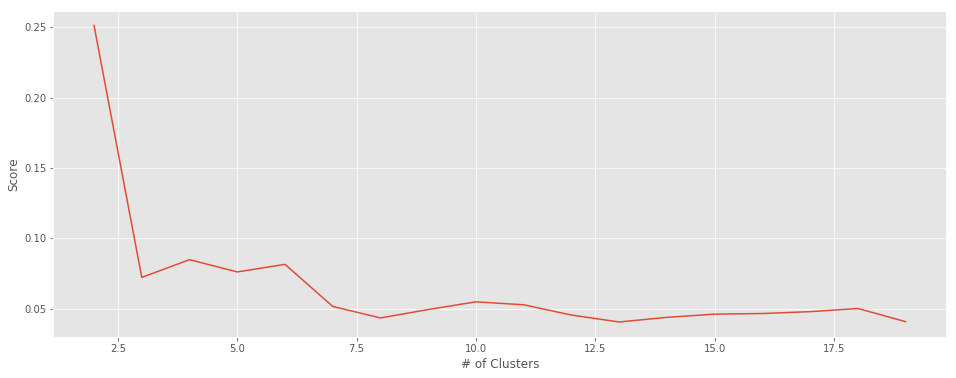

Max Value:
Cluster #    Cluster Score
7       2.769947

Min Value:
Cluster #    Cluster Score
2       1.773727


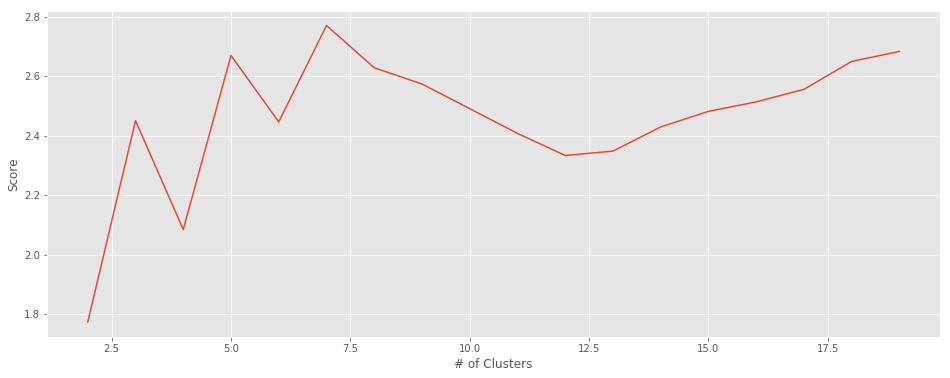

In [46]:
def plot_evaluation(y, x=cluster_cnt):
    """
    Plots the scores of a set evaluation metric. Prints out the max and min values of the evaluation scores.
    """
    
    # Creating a DataFrame for returning the max and min scores for each cluster
    df = pd.DataFrame(columns=['Cluster Score'], index=[i for i in range(2, len(y)+2)])
    df['Cluster Score'] = y
    
    print('Max Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].max()])
    print('\nMin Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].min()])
    
    # Plotting out the scores based on cluster count
    plt.figure(figsize=(16,6))
    plt.style.use('ggplot')
    plt.plot(x,y)
    plt.xlabel('# of Clusters')
    plt.ylabel('Score')
    plt.show()
    
# Running the function on the list of scores
plot_evaluation(s_scores)

plot_evaluation(db_scores)

In [47]:
def cluster_eval(y, x):
    """
    Prints the scores of a set evaluation metric. Prints out the max and min values of the evaluation scores.
    """
    
    # Creating a DataFrame for returning the max and min scores for each cluster
    df = pd.DataFrame(columns=['Cluster Score'], index=[i for i in range(2, len(y)+2)])
    df['Cluster Score'] = y
    
    print('Max Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].max()])
    print('\nMin Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].min()])
    
    
print("\nThe Silhouette Coefficient Score (find max score):")
cluster_eval(s_scores, cluster_cnt)

print("\nThe Davies-Bouldin Score (find minimum score):")
cluster_eval(db_scores, cluster_cnt)


The Silhouette Coefficient Score (find max score):
Max Value:
Cluster #    Cluster Score
2       0.251214

Min Value:
Cluster #     Cluster Score
13       0.040668

The Davies-Bouldin Score (find minimum score):
Max Value:
Cluster #    Cluster Score
7       2.769947

Min Value:
Cluster #    Cluster Score
2       1.773727


Either evaluation score can be used, therefore I choose the Davies-Bouldin. Since clusters fall between 2 and 7, I will choose 4 since it is a midpoint between both numbers.

### Re-Train Model

In [48]:
# Instantiate HAC
hac = AgglomerativeClustering(n_clusters=4)

# Fit Model
hac.fit(df)

# Get Cluster Assignments
cluster_assignments = hac.labels_

# Assign the clusters to each profile
df['Cluster #'] = cluster_assignments

# View the dating profiles with assigned clusters
df

,age,height,income,status,sex,orientation,body_type,diet,drinks,drugs,...,ethnicity,job,location,offspring,pets,religion,sign,smokes,speaks,Cluster #
0,-1.046113,1.704661,-0.260293,0.249502,0.885557,0.366512,-1.183651,1.223845,0.575603,-0.530302,...,-1.374085,1.539594,1.106869,-0.364823,0.862914,-1.070512,-0.590594,0.483260,-1.001739,0
1,-0.058895,0.955689,-0.260293,0.249502,0.885557,0.366512,-0.823306,-0.582240,0.575603,-0.530302,...,0.622970,1.211293,0.626716,-0.987870,0.862914,-0.027051,0.424914,-0.438301,-0.999108,0
2,-0.328136,0.206717,-0.260293,0.249502,0.885557,0.366512,0.257728,-0.582240,0.575603,-0.530302,...,0.622970,-0.430210,0.626716,-0.364823,0.862914,-1.135728,0.787596,-0.438301,1.970918,0
3,-0.417883,-0.292598,0.076503,0.249502,0.885557,0.366512,0.257728,-0.582240,0.575603,1.929740,...,0.622970,-1.579262,0.626716,0.258225,0.862914,-1.070512,-0.010304,-0.438301,-0.999108,0
4,-0.238389,-0.542256,-0.260293,0.249502,-1.129233,0.366512,-0.102617,-1.098264,0.575603,1.929740,...,0.622970,-0.430210,0.626716,-0.364823,-0.100812,-0.940079,0.279842,-0.438301,-0.999108,0
5,1.018071,-1.041571,-0.260293,0.249502,-1.129233,0.366512,0.257728,-0.582240,0.575603,-0.530302,...,-2.358141,-0.430210,-0.669698,-0.987870,-0.100812,-1.200945,-1.243421,-0.438301,-0.999108,0
6,-0.956366,-0.542256,-0.091891,0.249502,-1.129233,0.366512,-0.102617,-0.582240,-0.394448,-0.530302,...,-1.142542,0.390541,0.626716,0.569748,0.862914,1.342491,-0.735667,2.326384,-0.999108,0
7,1.466807,1.704661,-0.260293,0.249502,0.885557,0.366512,0.257728,-0.582240,0.575603,-0.530302,...,0.622970,1.703744,1.298931,1.815843,-2.670747,0.168597,-0.372985,-0.438301,1.176456,2
8,-1.135860,0.456374,8.159412,0.249502,0.885557,0.366512,2.419796,1.223845,0.575603,0.699719,...,-0.679457,0.062241,0.626716,-0.676346,-0.100812,-0.874863,0.715060,0.483260,-1.001739,3
9,1.466807,1.205346,0.413291,0.249502,0.885557,0.366512,-0.462962,-0.582240,-1.364498,-0.530302,...,0.622970,1.539594,-2.110158,0.258225,-2.028263,1.342491,-0.010304,-0.438301,-1.001739,0


In [49]:
# Rearranging columns so that Cluster # is the first
cols = df.columns.tolist()

In [50]:
cols

['age',
 'height',
 'income',
 'status',
 'sex',
 'orientation',
 'body_type',
 'diet',
 'drinks',
 'drugs',
 'education',
 'ethnicity',
 'job',
 'location',
 'offspring',
 'pets',
 'religion',
 'sign',
 'smokes',
 'speaks',
 'Cluster #']

In [51]:
cols = cols[-1:] + cols[:-1]

In [52]:
cols

['Cluster #',
 'age',
 'height',
 'income',
 'status',
 'sex',
 'orientation',
 'body_type',
 'diet',
 'drinks',
 'drugs',
 'education',
 'ethnicity',
 'job',
 'location',
 'offspring',
 'pets',
 'religion',
 'sign',
 'smokes',
 'speaks']

In [53]:
df = df[cols]

In [54]:
df

,Cluster #,age,height,income,status,sex,orientation,body_type,diet,drinks,...,education,ethnicity,job,location,offspring,pets,religion,sign,smokes,speaks
0,0,-1.046113,1.704661,-0.260293,0.249502,0.885557,0.366512,-1.183651,1.223845,0.575603,...,1.303910,-1.374085,1.539594,1.106869,-0.364823,0.862914,-1.070512,-0.590594,0.483260,-1.001739
1,0,-0.058895,0.955689,-0.260293,0.249502,0.885557,0.366512,-0.823306,-0.582240,0.575603,...,-0.152947,0.622970,1.211293,0.626716,-0.987870,0.862914,-0.027051,0.424914,-0.438301,-0.999108
2,0,-0.328136,0.206717,-0.260293,0.249502,0.885557,0.366512,0.257728,-0.582240,0.575603,...,-0.638567,0.622970,-0.430210,0.626716,-0.364823,0.862914,-1.135728,0.787596,-0.438301,1.970918
3,0,-0.417883,-0.292598,0.076503,0.249502,0.885557,0.366512,0.257728,-0.582240,0.575603,...,-0.638567,0.622970,-1.579262,0.626716,0.258225,0.862914,-1.070512,-0.010304,-0.438301,-0.999108
4,0,-0.238389,-0.542256,-0.260293,0.249502,-1.129233,0.366512,-0.102617,-1.098264,0.575603,...,-0.152947,0.622970,-0.430210,0.626716,-0.364823,-0.100812,-0.940079,0.279842,-0.438301,-0.999108
5,0,1.018071,-1.041571,-0.260293,0.249502,-1.129233,0.366512,0.257728,-0.582240,0.575603,...,-0.152947,-2.358141,-0.430210,-0.669698,-0.987870,-0.100812,-1.200945,-1.243421,-0.438301,-0.999108
6,0,-0.956366,-0.542256,-0.091891,0.249502,-1.129233,0.366512,-0.102617,-0.582240,-0.394448,...,1.303910,-1.142542,0.390541,0.626716,0.569748,0.862914,1.342491,-0.735667,2.326384,-0.999108
7,2,1.466807,1.704661,-0.260293,0.249502,0.885557,0.366512,0.257728,-0.582240,0.575603,...,0.494545,0.622970,1.703744,1.298931,1.815843,-2.670747,0.168597,-0.372985,-0.438301,1.176456
8,3,-1.135860,0.456374,8.159412,0.249502,0.885557,0.366512,2.419796,1.223845,0.575603,...,2.275148,-0.679457,0.062241,0.626716,-0.676346,-0.100812,-0.874863,0.715060,0.483260,-1.001739
9,0,1.466807,1.205346,0.413291,0.249502,0.885557,0.366512,-0.462962,-0.582240,-1.364498,...,-1.933551,0.622970,1.539594,-2.110158,0.258225,-2.028263,1.342491,-0.010304,-0.438301,-1.001739


### Sorting Clusters

In [55]:
# import random

# # Randomly choose a cluster
# rand_cluster = random.choice(df['Cluster #'].unique())

# # Assigning the Cluster Profiles as a new DF
# group = df[df['Cluster #']==rand_cluster].drop('Cluster #', axis=1)

In [56]:
#group

### Looking for Correlations among users

In [64]:
corr_group = df.T.corr()

In [77]:
corr_group

,0,1,2,3,4,5,6,7,8,9,...,4397,4398,4399,4400,4401,4402,4403,4404,4405,4406
0,1.000000,0.505707,-0.090075,-0.112891,-0.170830,0.138987,0.272741,0.008690,0.091925,-0.219420,...,-0.493920,0.472929,-0.223702,-0.289626,0.010785,-0.161885,-0.312443,-0.014032,0.260652,0.611792
1,0.505707,1.000000,0.191916,0.071360,0.092814,-0.096138,-0.088359,0.025395,-0.136036,0.182306,...,-0.606603,0.428034,0.313030,-0.570181,-0.046795,-0.249947,-0.091559,-0.067271,0.257619,0.072332
2,-0.090075,0.191916,1.000000,0.232243,0.004778,-0.161345,-0.475114,-0.008350,-0.177902,-0.305575,...,0.125440,0.161904,0.084393,-0.193617,-0.498706,-0.421897,0.462102,0.568168,0.075816,0.182157
3,-0.112891,0.071360,0.232243,1.000000,0.684415,0.009834,-0.244337,-0.322031,0.089501,-0.310479,...,0.118877,-0.277430,0.587929,-0.205779,-0.481669,-0.075734,0.577101,0.111925,0.585652,0.053538
4,-0.170830,0.092814,0.004778,0.684415,1.000000,0.133656,-0.073834,-0.148586,0.023055,-0.280275,...,0.305699,-0.218464,0.587046,-0.287117,-0.136037,-0.056998,0.426918,0.212063,0.472315,-0.042349
5,0.138987,-0.096138,-0.161345,0.009834,0.133656,1.000000,0.169870,-0.049655,0.193266,-0.163582,...,0.148803,-0.137801,-0.204693,-0.197355,-0.104150,-0.175389,-0.110010,0.505140,-0.140234,0.265887
6,0.272741,-0.088359,-0.475114,-0.244337,-0.073834,0.169870,1.000000,-0.234091,0.030929,-0.260206,...,-0.379507,0.265497,-0.159755,0.107555,0.595952,0.326856,-0.339560,0.022395,-0.062625,0.322888
7,0.008690,0.025395,-0.008350,-0.322031,-0.148586,-0.049655,-0.234091,1.000000,-0.130047,0.416444,...,0.176947,0.042487,-0.368779,0.194650,-0.105876,0.223145,-0.199776,-0.255477,-0.240943,-0.058437
8,0.091925,-0.136036,-0.177902,0.089501,0.023055,0.193266,0.030929,-0.130047,1.000000,-0.097028,...,-0.139577,-0.031090,-0.073960,-0.116245,-0.047541,-0.021957,0.087076,0.070462,0.153226,0.018054
9,-0.219420,0.182306,-0.305575,-0.310479,-0.280275,-0.163582,-0.260206,0.416444,-0.097028,1.000000,...,-0.116488,-0.105261,-0.075206,-0.014776,0.268221,0.121842,-0.162617,-0.599296,-0.246924,-0.419795


In [78]:
# Top 5 Most Similar Users to User 1
corr_group[1].sort_values(ascending=False).head()

1       1.000000
1816    0.945333
2640    0.926552
17      0.870356
3780    0.870343
Name: 1, dtype: float64

### Model Evaluation: Showing Users their Top 10 Picks!

In [59]:
## Finding the Top 10 Similar Users

# Randomly selecting a user
random_user = random.choice(corr_group.index)

print("Top 10 most similar users to User #", random_user, '\n')

# Creating a DF with the top 10 most similar users to the selected user
top_10_sim = corr_group[[random_user]].sort_values(by=[random_user],axis=0, ascending=False)[1:11]

# Printing out the results
print(top_10_sim)

print("\nThe most similar user to User #", random_user, "is User #", top_10_sim.index[0])

Top 10 most similar users to User # 35 

            35
1093  0.899169
3088  0.896974
2996  0.882845
1459  0.881134
2627  0.873437
2634  0.869427
2106  0.866019
2464  0.862243
2071  0.862239
2561  0.856421

The most similar user to User # 35 is User # 1093


Thank you for reading. Questions? Contact Jody-Ann Jones, Ph.D., jasjones82@gmail.com